In [1]:
import pandas as pd
import datetime
import requests
import json
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
from coinmetrics.api_client import CoinMetricsClient
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense,BatchNormalization
from keras.layers import Dropout, Activation
from keras import regularizers, initializers
from sklearn.preprocessing import MinMaxScaler
from keras.layers import TimeDistributed


import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
SYMBOL      = cfg['SYMBOL']
STABLECOIN  = cfg['STABLECOIN']
PAIR        = SYMBOL + STABLECOIN #binance
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']
TEST_SIZE   = 720

In [2]:
def round_float_cols(
    data: pd.DataFrame, 
    howmanydecimals: int = 2
) -> pd.DataFrame:

    for col in data.columns:
        if(data[col].dtype == np.float64):
            data[col] = data[col].round(howmanydecimals)

    return data


def datetime_to_ts(date_time) -> int:
    print(type(date_time))
    if type(date_time)==datetime.date:
        print('passo de qui')
        return int(datetime.datetime.combine(date_time, datetime.time.min).timestamp()*1000)
    elif type(date_time)==datetime:
        print('passo de qui')
        return int(date_time.timestamp()*1000)

def ts_to_datetime(ts) -> str:
    
    return datetime.datetime.fromtimestamp(ts / 1000.0)

def download_data(client, pair, cols, PARAMS):

    client.klines(pair, interval=PARAMS['interval'], limit=1, startTime=PARAMS['startTime'])
    # Get server timestamp
    print(ts_to_datetime(client.time()['serverTime']))
    # Get klines of BTCUSDT at 1m interval
    start_timestamp = ts_to_datetime(client.klines(pair, interval=PARAMS['interval'], limit=1, startTime=PARAMS['startTime'])[0][0])
    end_timestamp = ts_to_datetime(PARAMS['endTime'])
    print(f'Exploring range {start_timestamp} - {end_timestamp}')

    df = pd.DataFrame()
    limit = 1000
    if end_timestamp <= start_timestamp: 

        print('No data are available for specified range')
    else:

        datediff = (end_timestamp - start_timestamp).days
        while datediff > 0:

            print(datediff)
            tmp_df = pd.DataFrame(client.klines(
                                            pair, 
                                            interval=PARAMS['interval'], 
                                            limit=limit, 
                                            startTime=datetime_to_ts(start_timestamp)
                                            )
            )

            start_timestamp += datetime.timedelta(days=limit)
            df = pd.concat([df, tmp_df], ignore_index=True)  
            datediff = (end_timestamp - start_timestamp).days
        
        df.columns = cols
    
    df['Symbol'] = pair
    df['OpenTimestamp'] = df['OpenTimestamp'].apply(ts_to_datetime)
    df['CloseTimestamp'] = df['CloseTimestamp'].apply(ts_to_datetime)

    dict_types= {
                'OpenTimestamp'                 :  'datetime64[ns]',
                'Open'                          :  'float64',
                'High'                          :  'float64',
                'Low'                           :  'float64',
                'Close'                         :  'float64',
                'Volume'                        :  'float64',
                'CloseTimestamp'                :  'datetime64[ns]',
                'Quote asset volume'            :  'float64',
                'Number of trades'              :  'int64',
                'Taker buy base asset volume'   :  'float64',
                'Taker buy quote asset volume'  :  'float64',
                'Ignore.'                       :  'int64',
                'Symbol'                        :  'str'
    }

    df= df.astype(dict_types)
    return df

def load_data(
            source: str,
            pair: str, 
            data_path, 
            PARAMS, 
            col_names, 
            overwrite: bool=False
) -> pd.DataFrame:

    file_name = pair.upper() + '_' + PARAMS['interval'] + '.csv'
    file_path = os.path.join(data_path,file_name)

    if not path.exists(file_path):
        print(f"File {file_name} not found.")
        df = download_data(source, pair, col_names, PARAMS)
        df.to_csv(file_path, index=False)
    else:
        if overwrite:
            print(f"Overfriting file {file_name}.")
            df = download_data(source, pair, col_names, PARAMS)
            df.to_csv(file_path, index=False)
        else:
            print(f"Loading {file_name}.")
            df = pd.read_csv(file_path)

    dict_types= {
                'OpenTimestamp'                 :  'datetime64[ns]',
                'Open'                          :  'float64',
                'High'                          :  'float64',
                'Low'                           :  'float64',
                'Close'                         :  'float64',
                'Volume'                        :  'float64',
                'CloseTimestamp'                :  'datetime64[ns]',
                'Quote asset volume'            :  'float64',
                'Number of trades'              :  'int64',
                'Taker buy base asset volume'   :  'float64',
                'Taker buy quote asset volume'  :  'float64',
                'Ignore.'                       :  'int64',
                'Symbol'                        :  'str'
    }
    
    df = df.astype(dict_types)
    return df

In [3]:
if SOURCE == 'BINANCE':
    PARAMS.update({'startTime': datetime_to_ts(PARAMS['startTime'])})
    PARAMS.update({'endTime': datetime_to_ts(PARAMS['endTime'])})

PARAMS  

<class 'datetime.date'>
passo de qui
<class 'datetime.date'>
passo de qui


{'interval': '1h', 'startTime': 1609455600000, 'endTime': 1676329200000}

In [4]:
import yfinance as yf

ticker = "BTC-USD"
interval = "1h"

# Define the start and end dates
end_date = "2023-03-28"
start_date = (pd.to_datetime(end_date) - pd.Timedelta(hours=700)).strftime("%Y-%m-%d")

# Download the first chunk of historical data
data = yf.download(ticker, start=start_date, end=end_date, interval=interval)

# Download additional chunks of historical data if needed
while start_date > "2009-01-01":
    end_date = start_date
    start_date = (pd.to_datetime(start_date) - pd.Timedelta(hours=700)).strftime("%Y-%m-%d")
    chunk = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    data = pd.concat([chunk, data])

# Print the data
data = data.reset_index()
data.columns = ['Time','Open','High','Low','Close','Adj_Close','Volume']
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Time,Open,High,Low,Close,Adj_Close,Volume
0,2021-04-07 00:00:00,58176.500000,58411.582031,57828.640625,57834.101562,57834.101562,0.000000e+00
1,2021-04-07 01:00:00,57854.058594,57875.660156,57483.355469,57686.707031,57686.707031,2.553160e+08
2,2021-04-07 02:00:00,57689.023438,58009.136719,57689.023438,57888.945312,57888.945312,0.000000e+00
3,2021-04-07 03:00:00,57930.070312,58220.816406,57831.203125,58007.757812,58007.757812,6.234972e+08
4,2021-04-07 04:00:00,58037.417969,58085.027344,57461.117188,57765.246094,57765.246094,1.102926e+09
...,...,...,...,...,...,...,...
17055,2023-03-27 19:00:00,27095.126953,27133.275391,26969.734375,26969.734375,26969.734375,1.654579e+08
17056,2023-03-27 20:00:00,26955.593750,27048.527344,26931.812500,27039.443359,27039.443359,1.426002e+08
17057,2023-03-27 21:00:00,27038.716797,27170.974609,27017.257812,27170.974609,27170.974609,2.501898e+08
17058,2023-03-27 22:00:00,27175.632812,27225.681641,27107.619141,27115.328125,27115.328125,0.000000e+00


In [5]:
df = data.copy()
df.drop(columns='Adj_Close',inplace=True)

In [6]:
map_ohlc = {'Open':'Open','High':'High','Low':'Low','Close':'Close', 'Volume': 'Volume'}
lags_relevant = [13,30,99,200]

In [7]:
print(df.columns)
df['AVG_Candle_Price'] = (df[map_ohlc['Open']]+df[map_ohlc['High']]+df[map_ohlc['Low']]+df[map_ohlc['Close']])/4
for lag in lags_relevant:
    df['Close_lag_'+str(lag)+'d'] = df[map_ohlc['Close']].shift(lag)
    df['SMA_Close_'+str(lag)+'d'] = my_functions.rolling_kpi(df,map_ohlc['Close'],lag,'mean', False)
    df['STD_Close_'+str(lag)+'d'] = my_functions.rolling_kpi(df,map_ohlc['Close'],lag,'std', False)
    df['VAR_Close_lag_'+str(lag)+'d'] = df['STD_Close_'+str(lag)+'d']**2

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [8]:
def return_index_if_exists(df_series, curr_idx, val, pos_crit, max_length):
    
    current_val = val

    if pos_crit:  

        try:

            thing_index = list(el > current_val for el in df_series[curr_idx+1:]).index(True) +1
        except ValueError:
            thing_index = max_length
    else:

        try:
            
            thing_index = list(el < current_val for el in df_series[curr_idx+1:]).index(True) +1
        except ValueError:
            thing_index = max_length

    if thing_index > max_length:
        
        thing_index=max_length

    return thing_index

def labelize_output_according_criterion2(df: pd.DataFrame, map_ohlc:dict, wrt:str='Close', threshold:float=0.015, risk_reward_ratio:float=0.5, max_trade_length:int=5) -> pd.DataFrame:
    
    df_ = df.copy()
    positive_criterion = 1 + threshold/risk_reward_ratio
    negative_criterion = 1 - threshold
    
    min_above = []
    min_below = []

    df_['TP'] = df_[map_ohlc[wrt]]*positive_criterion
    df_['SL'] = df_[map_ohlc[wrt]]*negative_criterion

    for idx,row in df_.iterrows():

        pos_val = positive_criterion*row[map_ohlc[wrt]]
        neg_val = negative_criterion*row[map_ohlc[wrt]]

        if idx != df_.index[-1]:
            candidates_above_minima = []
            candidates_below_minima = []
            for _,v in map_ohlc.items():
                candidates_above_minima.append(return_index_if_exists(df_[v], idx, pos_val, True, max_trade_length))
                candidates_below_minima.append(return_index_if_exists(df_[v], idx, neg_val, False, max_trade_length))

            min_above.append(min(candidates_above_minima))
            min_below.append(min(candidates_below_minima))

    min_above.append(None)
    min_below.append(None)

    df_['min_above'] = min_above
    df_['min_below'] = min_below


    return df_

In [9]:
df = labelize_output_according_criterion2(df, map_ohlc, max_trade_length=MAX_LENGTH)
df['signal'] = (df['min_above'].lt(df['min_below'])) & (df['min_above'] <= MAX_LENGTH)
df['signal']=df['signal'].astype(int)
df.drop(columns=['CloseAbovethreshold', 'HighAbovethreshold',
       'LowAbovethreshold', 'OpenAbovethreshold', 'CloseBelowthreshold',
       'HighBelowthreshold', 'LowBelowthreshold', 'OpenBelowthreshold', 'TP',
       'SL', 'min_above', 'min_below'], inplace=True, errors='ignore')
df = df.dropna().reset_index(drop=True)
df.head()

,Time,Open,High,Low,Close,Volume,AVG_Candle_Price,Close_lag_13d,SMA_Close_13d,STD_Close_13d,...,VAR_Close_lag_30d,Close_lag_99d,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,signal
0,2021-04-15 16:00:00,62912.125000,63121.402344,62769.945312,62928.882812,0.0,62933.088867,63205.480469,62854.321514,242.012831,...,314318.415658,59651.984375,61858.099116,1599.422584,2.558153e+06,57834.101562,60094.673867,2295.579057,5.269683e+06,0
1,2021-04-15 17:00:00,62877.390625,62910.855469,62607.507812,62730.191406,0.0,62781.486328,63078.894531,62827.498197,234.247802,...,271988.989053,59668.335938,61889.026949,1586.196004,2.516018e+06,57686.707031,60119.891289,2296.695707,5.274811e+06,0
2,2021-04-15 18:00:00,62770.718750,63068.898438,62717.566406,62987.867188,0.0,62886.262695,63216.437500,62809.915865,209.938489,...,176801.084347,59810.757812,61921.118963,1575.825110,2.483225e+06,57888.945312,60145.385898,2300.104426,5.290480e+06,0
3,2021-04-15 19:00:00,62986.046875,63728.789062,62986.046875,63606.074219,0.0,63326.739258,63033.210938,62853.982272,301.061101,...,145310.560091,59710.808594,61960.465080,1568.687111,2.460779e+06,58007.757812,60173.377480,2308.010736,5.326914e+06,1
4,2021-04-15 20:00:00,63590.605469,63764.417969,63477.437500,63534.679688,743178240.0,63591.785156,63014.656250,62893.984075,354.069721,...,123113.972295,59402.390625,62002.205374,1554.841978,2.417534e+06,57765.246094,60202.224648,2313.808909,5.353712e+06,0


In [11]:
from sklearn.preprocessing import PowerTransformer

def yeojohntrans(df, feature):   # function to apply transformer and check the distribution with histogram and kdeplot
    
    yeojohnTr = PowerTransformer(standardize=True)   # not using method attribute as yeo-johnson is the default

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=15)
    sns.histplot(df[feature], kde=True, color="red")
    plt.subplot(1,2,2)
    
    df_yeojohn = pd.DataFrame(yeojohnTr.fit_transform(df[feature].values.reshape(-1,1)))
    plt.title("Distribution after Transformation", fontsize=15)
    sns.histplot(df_yeojohn,bins=20, kde=True , legend=False)
    plt.xlabel(feature)
    plt.show()
    
    print(f"Skewness was {round(df[feature],2)} before & is {round(df_yeojohn.skew()[0],2)} after Yeo-johnson transformation.")
    

In [ ]:
df_analysis = df.copy()

features = [col for col in df_analysis.columns if col not in ['market','time','signal']]
fig, axs = plt.subplots(nrows=int(len(features)/3), ncols=3, figsize=(18,5*int(len(features)/3)))
for i,feature in enumerate(features):
    df_analysis[feature] = df_analysis[feature] - df_analysis[feature].shift()
    single_feature = df_analysis[feature][1:]
    sns.histplot(data=single_feature,kde=True, stat='density', ax=axs[int(i/3)][i%3])

plt.show()


In [10]:
df_btc = df.copy()
df_btc.dropna(inplace=True)
df_btc.drop(columns='market', inplace=True, errors='ignore')
df_btc = df_btc.reset_index(drop=True)
df_btc.head()

,Time,Open,High,Low,Close,Volume,AVG_Candle_Price,Close_lag_13d,SMA_Close_13d,STD_Close_13d,...,VAR_Close_lag_30d,Close_lag_99d,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,signal
0,2021-04-15 16:00:00,62912.125000,63121.402344,62769.945312,62928.882812,0.0,62933.088867,63205.480469,62854.321514,242.012831,...,314318.415658,59651.984375,61858.099116,1599.422584,2.558153e+06,57834.101562,60094.673867,2295.579057,5.269683e+06,0
1,2021-04-15 17:00:00,62877.390625,62910.855469,62607.507812,62730.191406,0.0,62781.486328,63078.894531,62827.498197,234.247802,...,271988.989053,59668.335938,61889.026949,1586.196004,2.516018e+06,57686.707031,60119.891289,2296.695707,5.274811e+06,0
2,2021-04-15 18:00:00,62770.718750,63068.898438,62717.566406,62987.867188,0.0,62886.262695,63216.437500,62809.915865,209.938489,...,176801.084347,59810.757812,61921.118963,1575.825110,2.483225e+06,57888.945312,60145.385898,2300.104426,5.290480e+06,0
3,2021-04-15 19:00:00,62986.046875,63728.789062,62986.046875,63606.074219,0.0,63326.739258,63033.210938,62853.982272,301.061101,...,145310.560091,59710.808594,61960.465080,1568.687111,2.460779e+06,58007.757812,60173.377480,2308.010736,5.326914e+06,1
4,2021-04-15 20:00:00,63590.605469,63764.417969,63477.437500,63534.679688,743178240.0,63591.785156,63014.656250,62893.984075,354.069721,...,123113.972295,59402.390625,62002.205374,1554.841978,2.417534e+06,57765.246094,60202.224648,2313.808909,5.353712e+06,0


In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
#df_btc.drop(columns=['price_close','price_high','price_low','candle_usd_volume', 'vwap','volume','candle_trades_count','Dxy_Close'], inplace=True)
df_btc

,Time,Open,High,Low,Close,Volume,AVG_Candle_Price,Close_lag_13d,SMA_Close_13d,STD_Close_13d,...,VAR_Close_lag_30d,Close_lag_99d,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,signal
0,2021-04-15 16:00:00,62912.125000,63121.402344,62769.945312,62928.882812,0.0,62933.088867,63205.480469,62854.321514,242.012831,...,314318.415658,59651.984375,61858.099116,1599.422584,2.558153e+06,57834.101562,60094.673867,2295.579057,5.269683e+06,0
1,2021-04-15 17:00:00,62877.390625,62910.855469,62607.507812,62730.191406,0.0,62781.486328,63078.894531,62827.498197,234.247802,...,271988.989053,59668.335938,61889.026949,1586.196004,2.516018e+06,57686.707031,60119.891289,2296.695707,5.274811e+06,0
2,2021-04-15 18:00:00,62770.718750,63068.898438,62717.566406,62987.867188,0.0,62886.262695,63216.437500,62809.915865,209.938489,...,176801.084347,59810.757812,61921.118963,1575.825110,2.483225e+06,57888.945312,60145.385898,2300.104426,5.290480e+06,0
3,2021-04-15 19:00:00,62986.046875,63728.789062,62986.046875,63606.074219,0.0,63326.739258,63033.210938,62853.982272,301.061101,...,145310.560091,59710.808594,61960.465080,1568.687111,2.460779e+06,58007.757812,60173.377480,2308.010736,5.326914e+06,1
4,2021-04-15 20:00:00,63590.605469,63764.417969,63477.437500,63534.679688,743178240.0,63591.785156,63014.656250,62893.984075,354.069721,...,123113.972295,59402.390625,62002.205374,1554.841978,2.417534e+06,57765.246094,60202.224648,2313.808909,5.353712e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2023-03-27 19:00:00,27095.126953,27133.275391,26969.734375,26969.734375,165457920.0,27041.967773,27799.730469,27467.318660,423.928580,...,119778.785453,28537.333984,27751.222834,328.082247,1.076380e+05,27262.371094,27836.577256,361.048733,1.303562e+05,1
16856,2023-03-27 20:00:00,26955.593750,27048.527344,26931.812500,27039.443359,142600192.0,26993.844238,27806.904297,27408.283203,426.129553,...,133528.307512,28315.408203,27738.334300,330.744364,1.093918e+05,27320.736328,27835.170791,363.607112,1.322101e+05,1
16857,2023-03-27 21:00:00,27038.716797,27170.974609,27017.257812,27170.974609,250189824.0,27099.480957,27847.941406,27356.208834,408.941740,...,140108.856655,27893.714844,27731.033894,335.225744,1.123763e+05,27247.613281,27834.787598,364.269212,1.326921e+05,0
16858,2023-03-27 22:00:00,27175.632812,27225.681641,27107.619141,27115.328125,0.0,27156.065430,27946.984375,27292.235276,372.223492,...,148764.227980,28376.617188,27718.293600,334.406632,1.118278e+05,27411.830078,27833.305088,366.595151,1.343920e+05,0


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
features = [col for col in df_btc.columns if col not in ['Time','signal']]
for feature in features:
     df_btc[feature] = df_btc[feature] - df_btc[feature].shift()
     df_btc[feature] = np.sqrt(np.absolute(df_btc[feature] - df_btc[feature].shift().fillna(0)))*np.sign(df_btc[feature] - df_btc[feature].shift().fillna(0))

df_btc['signal'] = df_btc['signal'].shift()
df_btc = df_btc.iloc[1:].reset_index(drop=True)

df_btc = my_functions.round_float_cols(df_btc)
#df_btc = df_btc.sample(frac=1).reset_index(drop=True)

scaler.fit(df_btc[features][:-TEST_SIZE])

X_train = df_btc[features][:-TEST_SIZE]
X_test = df_btc[features][-TEST_SIZE:]
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
Y_train = np.array(df_btc['signal'][:-TEST_SIZE])
Y_test = np.array(df_btc['signal'][-TEST_SIZE:])

#X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16139, 22)
(720, 22)
(16139,)
(720,)


In [59]:
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'lambda':.01,
    'max_depth':5,
    'scale_pos_weight':3,
    'objective':'binary:logistic',
    'colsample_bytree':.8,
    'eta':0.1,
    'n_estimators':3000,
    'early_stopping_rounds':200
    }

model = my_functions.model_selection('xgb',p)

print(model.get_params())

model.fit(X_train[:-TEST_SIZE], Y_train[:-TEST_SIZE], eval_set = [(X_train[:-TEST_SIZE], Y_train[:-TEST_SIZE],), (X_train[-TEST_SIZE:], Y_train[-TEST_SIZE:],)], verbose=0)
predictions = model.predict_proba(X_train[-TEST_SIZE:])[:,1]
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_train[-TEST_SIZE:], predictions)
print("Test set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))



{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': 200, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 3000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 3, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'lambda': 0.01, 'eta': 0.1}
Test set score: 0.85430


BUILD LSTM

Epoch 1/1000
646/646 [==============================] - 10s 12ms/step - loss: 0.6937 - auc: 0.5165 - accuracy: 0.5212 - val_loss: 0.6981 - val_auc: 0.5326 - val_accuracy: 0.4641
Epoch 2/1000
646/646 [==============================] - 7s 11ms/step - loss: 0.6884 - auc: 0.5485 - accuracy: 0.5446 - val_loss: 0.6959 - val_auc: 0.5397 - val_accuracy: 0.4641
Epoch 3/1000
646/646 [==============================] - 7s 11ms/step - loss: 0.6829 - auc: 0.5700 - accuracy: 0.5557 - val_loss: 0.6928 - val_auc: 0.5421 - val_accuracy: 0.4641
Epoch 4/1000
646/646 [==============================] - 7s 12ms/step - loss: 0.6798 - auc: 0.5772 - accuracy: 0.5645 - val_loss: 0.6910 - val_auc: 0.5381 - val_accuracy: 0.4641
Epoch 5/1000
646/646 [==============================] - 7s 11ms/step - loss: 0.6781 - auc: 0.5796 - accuracy: 0.5699 - val_loss: 0.6893 - val_auc: 0.5353 - val_accuracy: 0.4641
Epoch 6/1000
646/646 [==============================] - 7s 12ms/step - loss: 0.6758 - auc: 0.5842 - accuracy: 0.57

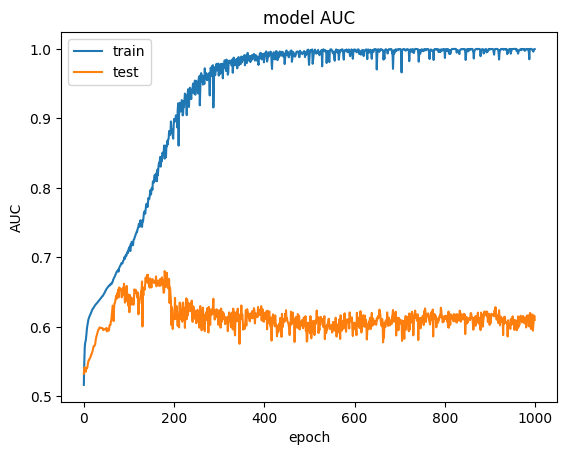

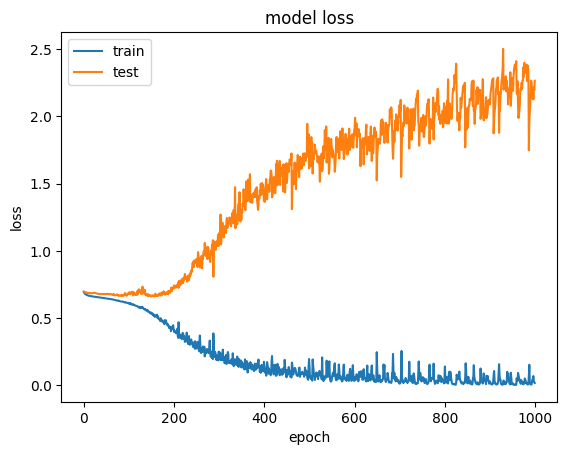

In [16]:
from keras.callbacks import EarlyStopping

from keras.layers.core import Dense, Dropout
from keras.optimizers import Adagrad


opt = tf.keras.optimizers.experimental.SGD(learning_rate=.2, weight_decay=0)


model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1],1)))#, kernel_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(LSTM(50, return_sequences=False, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
            optimizer=opt,
            loss=['binary_crossentropy'], 
            metrics=['AUC','accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, Y_train, batch_size=20, epochs=1000, validation_split=0.2, shuffle=False) #sample_weight_mode="temporal", sample)


# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [17]:
y_pr = model.predict(X_train)
y_pr


505/505 [==============================] - 4s 6ms/step


array([[1.3968359e-07],
       [2.5722708e-04],
       [3.6357058e-05],
       ...,
       [1.0920076e-02],
       [9.7625101e-01],
       [3.9096796e-03]], dtype=float32)

In [32]:
model2 = Sequential()
model2.add(LSTM(units=512, kernel_initializer='random_normal', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.3))
model2.add(LSTM(256))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'AUC'])
model2.summary()

# Fit the model to the data
history = model2.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 22, 512)           1052672   
                                                                 
 dropout_8 (Dropout)         (None, 22, 512)           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               787456    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,906,177
Trainable params: 1,906,177
No

In [ ]:
model3 = Sequential()
model3.add(LSTM(1025, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(LSTM(256, return_sequences=True))
model3.add(LSTM(128, return_sequences=False))   
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
model.fit(X_train, Y_train, epochs=10)

In [44]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = X_train
print(np.shape(X_train))
# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 24

# Step 3: Create empty lists to hold the inputs and outputs
X_train = []
Y_train = np.array(Y_train[window_size:])

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X_train.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X_train = np.array(X_train)

# Step 6: Reshape the input data into a 3D tensor
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
#X_train = np.transpose(X_train, (0, 2,1))


#X_test = data[-(TEST_SIZE+window_size): , : ]
X_test = []
Y_test = np.array(Y_test)

# Step 4: Loop through the data and create the inputs and outputs
for i in range(len(data)-TEST_SIZE, len(data)):
    X_test.append(data[i-window_size:i])

X_test = np.array(X_test)
#X_test = np.transpose(X_test, (0, 2,1))

print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_test), np.shape(Y_test))



(16139, 22)
(16115, 24, 22) (16115,)
(720, 24, 22) (720,)


In [47]:


#model = Sequential()
#model.add(LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01),  kernel_initializer=initializers.RandomNormal(stddev=0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(200, return_sequences=False))
#model.add(Dense(25))
#model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.experimental.SGD(learning_rate=.2)

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='mse', optimizer=opt)

model.summary()

model.compile(optimizer=opt, loss=['binary_crossentropy'], metrics=['AUC','accuracy'])
history = model.fit(X_train, Y_train, batch_size=10, epochs=100, validation_batch_size=0.2, shuffle=False)


"""import tensorflow as tf

model = Sequential()
model.add(Bidirectional(
    LSTM(500, input_shape=(X_train.shape[1], X_train.shape[2]))
    )
)
model.add(LSTM(200, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.experimental.Adam(
    learning_rate=0.02), loss='mean_squared_error', metrics=['accuracy'])


model.fit(X_train, Y_train, batch_size= 30, epochs=50, shuffle=False)"""

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 20)            3440      
                                                                 
 lstm_9 (LSTM)               (None, 24, 50)            14200     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 37,891
Trainable params: 37,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1612/1612 [==============================] - 44s 24ms/step - loss: 0.6929 - auc: 0.5024 - accuracy: 0.5216
Epoch 2/100
1612/1612 [==============================] - 40s 25

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


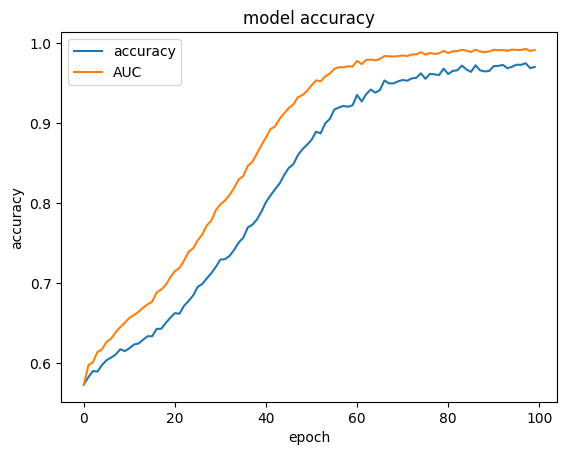

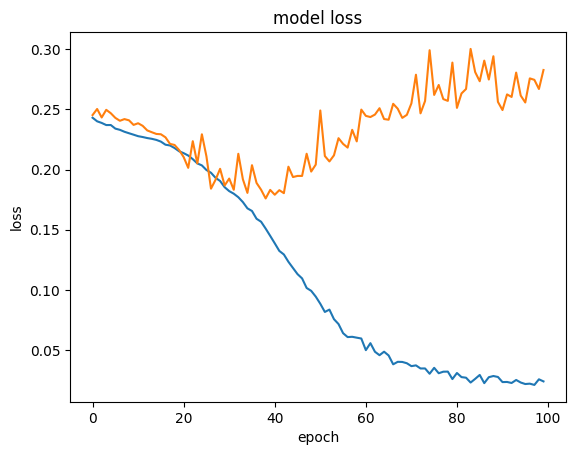

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'AUC'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
y_pr = model.predict(X_train)
y_pr

523/523 [==============================] - 7s 12ms/step


array([[0.46137884],
       [0.46136647],
       [0.46137354],
       ...,
       [0.46133852],
       [0.4612569 ],
       [0.46121606]], dtype=float32)

In [20]:
predictions = model.predict(X_test)
predictions = predictions[:,0]
predictions

23/23 [==============================] - 0s 8ms/step


array([4.62367535e-01, 2.40527660e-01, 8.22766066e-01, 9.36416669e-08,
       9.91647780e-01, 9.01434839e-01, 5.87249128e-03, 9.93281782e-01,
       5.78955514e-05, 9.93261099e-01, 9.93328452e-01, 8.18697501e-08,
       2.29652971e-02, 9.99999046e-01, 1.94596425e-01, 4.07232146e-04,
       9.97310102e-01, 1.68252771e-03, 9.99998808e-01, 9.87162232e-01,
       5.70634723e-01, 9.99974310e-01, 9.99227941e-01, 1.43323913e-01,
       3.86165222e-03, 9.38225925e-01, 5.20641565e-01, 1.65166017e-02,
       9.94368196e-01, 7.79206725e-03, 2.33892217e-01, 9.99992847e-01,
       9.99997377e-01, 1.17584341e-03, 3.58278930e-01, 7.12839095e-03,
       9.62902069e-01, 9.99999881e-01, 9.94640052e-01, 2.44185612e-01,
       6.82145417e-01, 2.75184284e-03, 9.99998391e-01, 1.49769783e-01,
       9.99608159e-01, 1.09477165e-04, 4.85749661e-06, 7.25006757e-05,
       8.96796167e-01, 7.09646894e-03, 2.71033078e-01, 5.15928134e-10,
       2.48569238e-04, 6.57115877e-02, 3.11642289e-01, 6.64973021e-01,
      

In [21]:
#predictions = (predictions-np.min(predictions))/(np.max(predictions)-np.min(predictions))

In [22]:
#my_functions.plt_correlation(train)

In [23]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in predictions]
    #precision = sklearn.metrics.accuracy_score(Y_test, y_pred) # average='weighted', beta=.5)
    precision = sklearn.metrics.fbeta_score(Y_test, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

0.5939001407580107
0.77


In [24]:
y_pred = [1 if el>thresh else 0 for el in predictions]

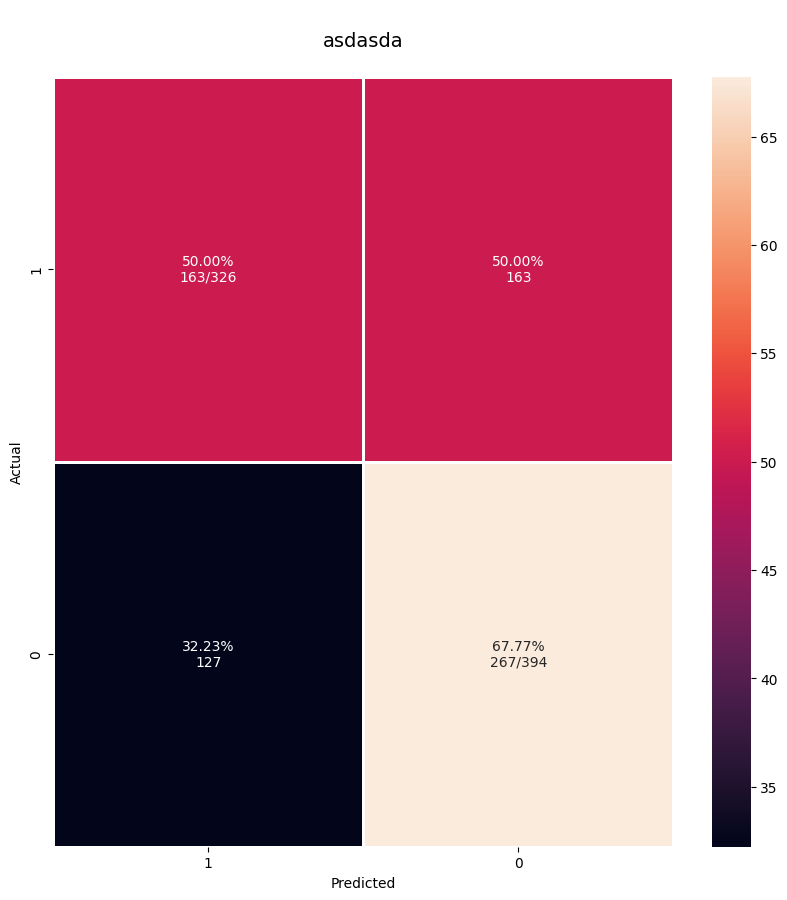

In [25]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(Y_test, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [43]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_test, predictions)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()

0.5302116786067194


In [ ]:
df.head()

In [ ]:
close_prices = df['price_close']
values = close_prices.values
training_data_len = int(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]



x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

print(np.shape(x_train), np.shape(y_train))

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(np.shape(x_train), np.shape(y_train))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(np.shape(x_test), np.shape(y_test))

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
data = df.filter(['price_close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price_close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = np.array(df[features])

# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 50

# Step 3: Create empty lists to hold the inputs and outputs
X = []
y = df['signal'][window_size:]

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Step 6: Reshape the input data into a 3D tensor
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))
X2 = np.transpose(X, (0, 2,1))
print(np.shape(X), np.shape(y))
print(np.shape(X2))




In [ ]:
y

In [ ]:
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adagrad


model = Sequential()
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(X2.shape[1],X2.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop',    
              metrics=['accuracy']
            )

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X2, y, batch_size= 1, epochs=3)

In [ ]:
y_test = model.predict(X2)

In [ ]:
y_test